In [1]:
import pandas as pd
import numpy as np
import os, sys
sys.path.insert(0, os.path.abspath('../..'))
import source.data_preparation as dp
import source.modelling_utils as utils
import source.models_classification as modl

import numpy as np
import pandas as pd
# Example


Transition matrix (rows sum to 1):
[[0.98708227 0.01291773]
 [0.04166358 0.95833642]]
Model converged: True
Converged in 40 iterations (tol = 0.01 )
State means: [ 0.00071555 -0.00128752]
State stds:  [0.00636463 0.0172233 ]
Bull state: 0, Bear state: 1


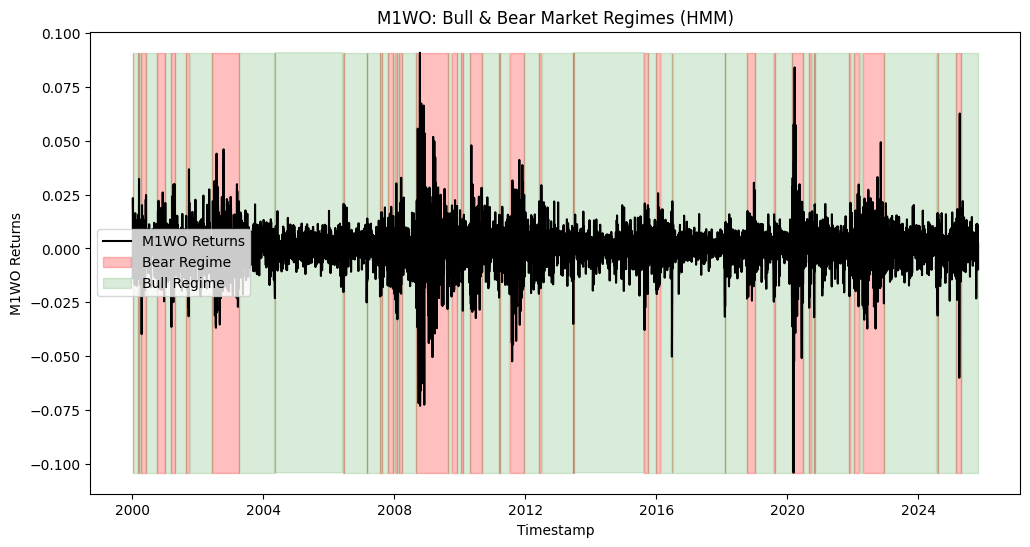

In [2]:
df = dp.create_classification_data(quiet=False)

In [5]:
df.shape

(6738, 17)

In [6]:
df

,timestamp,CL1,M1WO,SXXT,SPX,NKY,SPTR,EUR003M,FEDL01,GC1,V2X,MOVE,VIX,USYC2Y10,VXJ,state,regime
0,2000-01-05,-0.025368,-0.013681,-0.028356,0.001920,0.000000,0.002008,-0.002,0.03,-0.005656,3.484005,4.669927,3.273743,3.386084,3.258097,1,Bear
1,2000-01-06,-0.005232,-0.011378,-0.006598,0.000955,0.000000,0.001155,-0.010,0.13,0.001063,3.439777,4.655958,3.247658,3.072693,3.296207,1,Bear
2,2000-01-07,-0.022858,0.023399,0.031469,0.026730,-6.583663,0.026730,-0.009,0.07,0.001769,3.312002,4.583027,3.078233,2.747271,3.247658,1,Bear
3,2000-01-10,0.018409,0.011027,0.015271,0.011128,6.583663,0.011147,-0.005,0.13,-0.000707,3.309448,4.576050,3.077773,2.513656,3.247658,0,Bull
4,2000-01-11,0.043623,-0.003420,-0.004971,-0.013149,-3.338158,-0.013119,-0.002,-0.11,0.005995,3.330775,4.615418,3.113515,2.917771,3.151881,0,Bull
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6733,2025-10-27,-0.003094,0.010805,0.004416,0.012215,0.592428,0.012220,0.012,0.01,-0.028695,2.793794,4.202750,2.759377,3.889532,3.425890,0,Bull
6734,2025-10-28,-0.019102,0.001684,-0.000087,0.002285,3.717267,0.002290,-0.010,0.00,-0.008961,2.799547,4.209160,2.798500,3.879087,3.279406,0,Bull
6735,2025-10-29,0.005471,-0.000275,-0.000449,-0.000044,-3.842365,-0.000037,-0.008,0.00,0.004403,2.835241,4.185860,2.828496,3.862139,3.330775,0,Bull
6736,2025-10-30,0.001487,-0.009830,-0.001306,-0.009954,-4.115259,-0.009948,-0.016,-0.25,0.008050,2.825798,4.202900,2.827905,3.880863,3.249987,0,Bull


In [6]:
df.columns

Index(['timestamp', 'CL1', 'M1WO', 'SXXT', 'SPX', 'NKY', 'SPTR', 'EUR003M',
       'FEDL01', 'GC1', 'V2X', 'MOVE', 'VIX', 'USYC2Y10', 'VXJ', 'state',
       'regime'],
      dtype='object')

In [7]:
logit_lag_fit_predict = modl.make_logit_multifeature_lag_fit_predict_fn()

metrics, y_true, y_pred, dates = utils.expanding_oos_tabular_cls(
    data=df,
    model_fit_predict_fn=logit_lag_fit_predict,
    start_oos="2020-01-01",
)

print(metrics)

[Logit-lag-baseline] Valid obs=1523 | Acc=0.8864 (baseline=0.7413) | BalAcc=0.8504 (baseline=0.5643) | SS=0.5609
{'acc': 0.886408404464872, 'bal_acc': 0.8504300929991668, 'acc_baseline': 0.7413000656598818, 'bal_acc_baseline': 0.5642808890089847, 'skill_acc': 0.5609137055837565}


In [ ]:
metrics_tabpfn, y_true_tabpfn, y_pred_tabpfn, dates_tabpfn = modl.tabpfn_cls_oos(
    data=df,
    base_cols=["VIX", "USYC2Y10"],  # predictors you want to lag
    target_col="state",             # Bull/Bear label
    start_oos="2024-01-01",
    start_date="2000-01-05",
    n_lags=3,
    min_train=120,
    baseline_mode="majority",    # compare to majority baseline
    model_params="2.5",             # or None for V2 default
    quiet=False,
    model_name="TabPFN state classifier",
)

print(metrics_tabpfn)


RuntimeError: TabPFN not installed. Please `pip install tabpfn`.

In [3]:
fit_fn = modl.make_chronos_t5_cls_fit_predict_fn(
    feature_col=["M1WO"],   # or a list of your channels
    target_col="state",
    seq_len=30,                  # 128 is fine too, but 64 often enough for returns
    epochs=1,                    # 5 is fine IF we retrain often (incremental)
    retrain_every=1500,            # <--- Update weights every 25 steps
    lr=1e-3,                     # Slightly higher LR for MLP
    model_id="amazon/chronos-t5-small",
    return_proba=False,           # Better for analyzing performance
)

metrics, y_true, y_pred, dates = utils.expanding_oos_tabular_cls(
    data=df,
    target_col="state",
    start_oos="2020-01-01",
    start_date="1850-01-01",
    min_train=256,                     # recommend >= seq_len
    model_name="MOMENT-CLS",
    model_fit_predict_fn=fit_fn,
    baseline_mode="majority",
)

[Chronos] Loading amazon/chronos-t5-small on mps...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading weights:   0%|          | 0/131 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/131 [00:00<?, ?it/s]

T5ForSequenceClassification LOAD REPORT from: amazon/chronos-t5-small
Key                                 | Status  | 
------------------------------------+---------+-
classification_head.out_proj.bias   | MISSING | 
classification_head.dense.bias      | MISSING | 
classification_head.dense.weight    | MISSING | 
classification_head.out_proj.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


[Chronos Retrain] Step 1 | Epoch 1/1
[Chronos Retrain] Batch 2 | Loss: 0.6932
[Chronos Retrain] Batch 3 | Loss: 0.6440
[Chronos Retrain] Batch 4 | Loss: 0.5043
[Chronos Retrain] Batch 5 | Loss: 0.5540
[Chronos Retrain] Batch 6 | Loss: 0.7162
[Chronos Retrain] Batch 7 | Loss: 0.6130
[Chronos Retrain] Batch 8 | Loss: 0.4181
[Chronos Retrain] Batch 9 | Loss: 0.4985
[Chronos Retrain] Batch 10 | Loss: 0.4363
[Chronos Retrain] Batch 11 | Loss: 0.4650
[Chronos Retrain] Batch 12 | Loss: 0.3957
[Chronos Retrain] Batch 13 | Loss: 0.5211
[Chronos Retrain] Batch 14 | Loss: 0.4741
[Chronos Retrain] Batch 15 | Loss: 0.5235
[Chronos Retrain] Batch 16 | Loss: 0.4109
[Chronos Retrain] Batch 17 | Loss: 0.5079
[Chronos Retrain] Batch 18 | Loss: 0.3379
[Chronos Retrain] Batch 19 | Loss: 0.5124
[Chronos Retrain] Batch 20 | Loss: 0.5032
[Chronos Retrain] Batch 21 | Loss: 0.4894
[Chronos Retrain] Batch 22 | Loss: 0.6101
[Chronos Retrain] Batch 23 | Loss: 0.5164
[Chronos Retrain] Batch 24 | Loss: 0.4756
[Chro

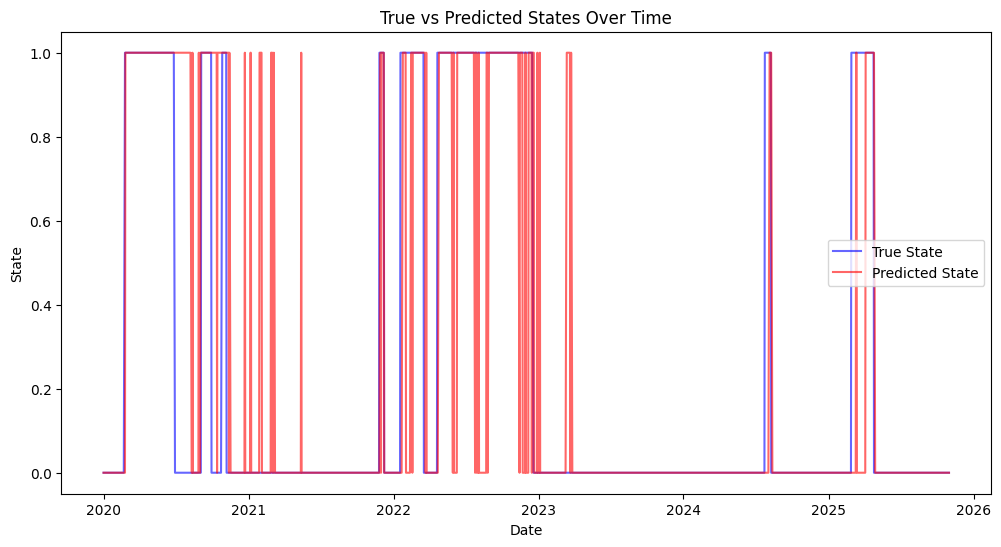

In [8]:
# create a plot of y_true, y_pred, dates for visual inspection
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(dates, y_true, label='True State', color='blue', alpha=0.6)
plt.plot(dates, y_pred, label='Predicted State', color='red', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('State')
plt.title('True vs Predicted States Over Time')
plt.legend()
plt.show()

In [ ]:
# pip install mantis-tsfm torch pandas numpy

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

from mantis.architecture import Mantis8M
from mantis.trainer import MantisTrainer


def _resize_to_512(X: torch.Tensor) -> torch.Tensor:
    # X: (N, C, L) -> (N, C, 512)
    return F.interpolate(X, size=512, mode="linear", align_corners=False)


def make_sliding_windows_single_channel(
    df: pd.DataFrame,
    feature_col: str = "M1WO",
    label_col: str = "state",
    date_col: str = "timestamp",
    window_len: int = 256,
    horizon: int = 1,          # 1-step-ahead
    do_cumsum: bool = False,   # optional "price path"
):
    """
    Returns:
      X: np.float32 (N, 1, 512)
      y: np.int64   (N,)
      t_end: np.datetime64[ns] (N,)
    """
    df = df.sort_values(date_col).reset_index(drop=True)

    times = pd.to_datetime(df[date_col]).to_numpy()
    x_all = df[feature_col].to_numpy(np.float32)  # (T,)
    y_all = df[label_col].to_numpy(np.int64)      # (T,)

    T = len(df)
    start_end = window_len - 1
    last_end = T - 1 - horizon
    if last_end < start_end:
        raise ValueError("Not enough rows. Reduce window_len or horizon.")

    X_list, y_list, t_list = [], [], []

    for end in range(start_end, last_end + 1):
        w = x_all[end - window_len + 1 : end + 1]  # (L,)

        if do_cumsum:
            w = np.cumsum(w)

        # shape to (C=1, L)
        w = w.reshape(1, -1)

        X_list.append(w)
        y_list.append(int(y_all[end + horizon]))
        t_list.append(times[end])

    X = torch.tensor(np.stack(X_list), dtype=torch.float32)  # (N, 1, L)
    X = _resize_to_512(X)                                    # (N, 1, 512)

    y = np.asarray(y_list, dtype=np.int64)
    t_end = np.asarray(t_list, dtype="datetime64[ns]")

    return X.numpy().astype(np.float32), y, t_end


def train_predict_mantis_single_channel(
    df: pd.DataFrame,
    feature_col: str = "M1WO",
    split_date: str = "2020-01-01",
    label_col: str = "state",
    date_col: str = "timestamp",
    window_len: int = 256,
    horizon: int = 1,
    do_cumsum: bool = False,
    num_epochs: int = 3,
    batch_size: int = 8,
    base_learning_rate: float = 1e-4,
    device: str = "cpu",   # safest on Mac
):
    # 1) Build windows
    X, y, t_end = make_sliding_windows_single_channel(
        df=df,
        feature_col=feature_col,
        label_col=label_col,
        date_col=date_col,
        window_len=window_len,
        horizon=horizon,
        do_cumsum=do_cumsum,
    )

    # 2) Split
    split_dt = np.datetime64(pd.to_datetime(split_date))
    train_mask = t_end < split_dt
    test_mask = t_end >= split_dt

    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test, t_test = X[test_mask], y[test_mask], t_end[test_mask]

    # 3) Load PRETRAINED Mantis-8M
    network = Mantis8M(device=device).from_pretrained("paris-noah/Mantis-8M")
    model = MantisTrainer(device=device, network=network)

    # 4) Fine-tune on your labels (backbone starts from pretrained weights)
    model.fit(
        X_train,
        y_train,
        num_epochs=10,
        # batch_size=batch_size,
        base_learning_rate=base_learning_rate,
    )

    # 5) Predict from 2020 onward
    probs = model.predict_proba(X_test)
    y_pred = model.predict(X_test)

    out = pd.DataFrame(
        {
            "timestamp": pd.to_datetime(t_test),
            "y_true": y_test,
            "y_pred": y_pred,
            "proba_class1": probs[:, 1] if probs.ndim == 2 and probs.shape[1] > 1 else np.nan,
        }
    ).reset_index(drop=True)

    return out


# -----------------------------
# USAGE
# -----------------------------
pred_df = train_predict_mantis_single_channel(
    df=df,
    feature_col="M1WO",
    split_date="2020-01-01",
    label_col="state",
    date_col="timestamp",
    window_len=256,
    horizon=1,
    do_cumsum=False,      # switch True if you want cumsum "price path"
    num_epochs=3,
    batch_size=8,         # increase if CPU RAM allows
    base_learning_rate=1e-4,
    device=DEVICE,
)

print(pred_df.head())
print(pred_df.tail())


Epoch 9: Train Loss 0.2260: 100%|██████████| 10/10 [01:38<00:00,  9.88s/it]


   timestamp  y_true  y_pred  proba_class1
0 2020-01-01       0       0      0.001797
1 2020-01-02       0       0      0.001666
2 2020-01-03       0       0      0.001921
3 2020-01-06       0       0      0.001920
4 2020-01-07       0       0      0.002310
      timestamp  y_true  y_pred  proba_class1
1517 2025-10-24       0       0      0.003054
1518 2025-10-27       0       0      0.003047
1519 2025-10-28       0       0      0.002136
1520 2025-10-29       0       0      0.002224
1521 2025-10-30       0       0      0.003372


In [3]:
# pip install mantis-tsfm torch pandas numpy

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

from mantis.architecture import Mantis8M
from mantis.trainer import MantisTrainer
if torch.backends.mps.is_available():
    DEVICE = "mps"
elif torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

print("Using device:", DEVICE)

def _resize_to_512(X: torch.Tensor) -> torch.Tensor:
    # X: (N, C, L) -> (N, C, 512)
    return F.interpolate(X, size=512, mode="linear", align_corners=False)


def make_sliding_windows_multi_channel(
    df: pd.DataFrame,
    feature_cols: list,
    label_col: str = "state",
    date_col: str = "timestamp",
    window_len: int = 256,
    horizon: int = 1,
    do_cumsum: bool = False,
):
    """
    Returns:
      X: np.float32 (N, C, 512)
      y: np.int64   (N,)
      t_end: np.datetime64[ns] (N,)
    """
    df = df.sort_values(date_col).reset_index(drop=True)

    times = pd.to_datetime(df[date_col]).to_numpy()
    X_all = df[feature_cols].to_numpy(np.float32)  # (T, C)
    y_all = df[label_col].to_numpy(np.int64)       # (T,)

    T, C = X_all.shape
    start_end = window_len - 1
    last_end = T - 1 - horizon
    if last_end < start_end:
        raise ValueError("Not enough rows. Reduce window_len or horizon.")

    X_list, y_list, t_list = [], [], []

    for end in range(start_end, last_end + 1):
        w = X_all[end - window_len + 1 : end + 1]  # (L, C)
        if do_cumsum:
            w = np.cumsum(w, axis=0)

        w = w.T  # (C, L)
        X_list.append(w)
        y_list.append(int(y_all[end + horizon]))
        t_list.append(times[end])

    X = torch.tensor(np.stack(X_list), dtype=torch.float32)  # (N, C, L)
    X = _resize_to_512(X)                                    # (N, C, 512)

    y = np.asarray(y_list, dtype=np.int64)
    t_end = np.asarray(t_list, dtype="datetime64[ns]")
    return X.numpy().astype(np.float32), y, t_end


def freeze_all_unfreeze_head(network: torch.nn.Module):
    """
    Freeze backbone parameters; unfreeze only head-like params.
    This keeps "features" fixed while still using MantisTrainer.fit/predict.
    """
    for p in network.parameters():
        p.requires_grad = False

    head_keys = ("head", "classifier", "fc", "linear", "proj", "prediction")
    n_unfrozen = 0
    for name, p in network.named_parameters():
        if any(k in name.lower() for k in head_keys):
            p.requires_grad = True
            n_unfrozen += p.numel()

    if n_unfrozen == 0:
        raise RuntimeError(
            "No head parameters were unfrozen. "
            "Print some parameter names and adjust head_keys:\n"
            "for n,_ in list(network.named_parameters())[:200]: print(n)"
        )


def train_predict_mantis_multichannel_head_only(
    df: pd.DataFrame,
    feature_cols: list,
    split_date: str = "2020-01-01",
    label_col: str = "state",
    date_col: str = "timestamp",
    window_len: int = 256,
    horizon: int = 1,
    do_cumsum: bool = False,
    num_epochs: int = 10,
    base_learning_rate: float = 1e-3,
    device: str = "cpu",
):
    # 1) Build windows
    X, y, t_end = make_sliding_windows_multi_channel(
        df=df,
        feature_cols=feature_cols,
        label_col=label_col,
        date_col=date_col,
        window_len=window_len,
        horizon=horizon,
        do_cumsum=do_cumsum,
    )

    # 2) Split by date (use the window end timestamp)
    split_dt = np.datetime64(pd.to_datetime(split_date))
    train_mask = t_end < split_dt
    test_mask = t_end >= split_dt

    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test, t_test = X[test_mask], y[test_mask], t_end[test_mask]

    # 3) Load pretrained Mantis
    network = Mantis8M(device=device).from_pretrained("paris-noah/Mantis-8M")

    # 4) Freeze backbone; train only head
    freeze_all_unfreeze_head(network)

    # 5) Train using fit()
    model = MantisTrainer(device=device, network=network)
    model.fit(
        X_train,
        y_train,
        num_epochs=num_epochs,
        base_learning_rate=base_learning_rate,
    )

    # 6) Predict
    probs = model.predict_proba(X_test)
    y_pred = model.predict(X_test)

    # 7) Output dataframe
    out = pd.DataFrame({"timestamp": pd.to_datetime(t_test), "y_true": y_test, "y_pred": y_pred})

    # Add per-class probabilities if available
    if probs.ndim == 2:
        for k in range(probs.shape[1]):
            out[f"proba_class{k}"] = probs[:, k]
    else:
        out["proba"] = probs

    return out, model


# -----------------------------
# USAGE (your dataframe columns)
# -----------------------------
# Pick your feature set (exclude label cols like "state"/"regime" and timestamp)
FEATURE_COLS = [
    "CL1","M1WO","SXXT","SPX","NKY",#"SPTR","EUR003M","FEDL01",
    #"GC1","V2X","MOVE","VIX","USYC2Y10","VXJ"
]

# df must already exist (as in your example)
pred_df, mantis_model = train_predict_mantis_multichannel_head_only(
    df=df,
    feature_cols=FEATURE_COLS,
    split_date="2020-01-01",
    label_col="state",
    date_col="timestamp",
    window_len=128,
    horizon=1,
    do_cumsum=False,
    num_epochs=10,
    base_learning_rate=1e-3,
    device=DEVICE,
)

print(pred_df.head())
print(pred_df.tail())


Using device: mps


Epoch 9: Train Loss 0.2312: 100%|██████████| 10/10 [33:28<00:00, 200.80s/it]


   timestamp  y_true  y_pred  proba_class0  proba_class1
0 2020-01-01       0       0      0.980179      0.019821
1 2020-01-02       0       0      0.982652      0.017348
2 2020-01-03       0       0      0.985538      0.014462
3 2020-01-06       0       0      0.964701      0.035299
4 2020-01-07       0       0      0.977563      0.022437
      timestamp  y_true  y_pred  proba_class0  proba_class1
1517 2025-10-24       0       0      0.993805      0.006195
1518 2025-10-27       0       0      0.990972      0.009028
1519 2025-10-28       0       0      0.996305      0.003695
1520 2025-10-29       0       0      0.990606      0.009394
1521 2025-10-30       0       0      0.992715      0.007285


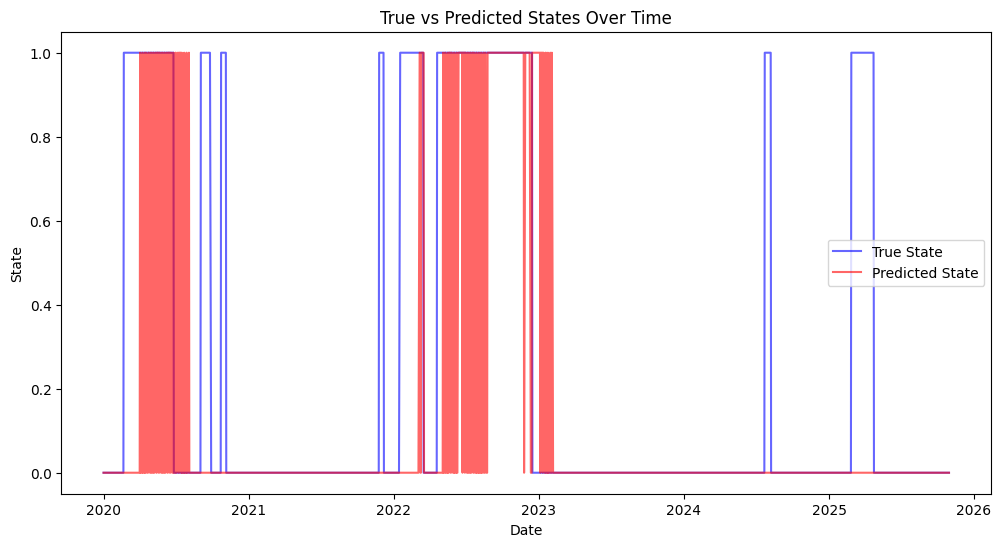

In [4]:
# create a plot of y_true, y_pred, dates for visual inspection
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(pred_df["timestamp"], pred_df["y_true"], label='True State', color='blue', alpha=0.6)
plt.plot(pred_df["timestamp"], pred_df["y_pred"], label='Predicted State', color='red', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('State')
plt.title('True vs Predicted States Over Time')
plt.legend()
plt.show()

In [ ]:
#create classifcation report
from sklearn.metrics import classification_report
print(classification_report(pred_df["y_true"], pred_df["y_pred"]))
